# 🔷 2D Wave Equation with Two Sources using Central Differences

We solve the damped wave equation in 2D:

$$
\frac{\partial^2 u}{\partial t^2} + \gamma \frac{\partial u}{\partial t} = c^2 \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right) + S(x, y, t)
$$

Where:
- $u(x,y,t)$ is the wave amplitude (e.g. ground displacement).
- $\gamma(x, y)$ is the damping coefficient.
- $c(x, y)$ is the wave speed.
- $S(x,y,t)$ is a source function.

We'll use central differences in both space and time (explicit FDTD).


## 🔁 Main Time-Stepping Loop (with Spatially Varying Damping and Wave Speed)

We solve the **damped 2D wave equation** with spatially varying coefficients:

$$
\frac{\partial^2 u}{\partial t^2} + \gamma(x, y) \frac{\partial u}{\partial t} = c(x, y)^2 \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right) + S(x, y, t)
$$

Using a **central difference scheme in time and space**, the update rule becomes:

### 🔢 Pointwise Scalar Form:

$$
u^{n+1}_{i,j} = (2 - \gamma_{i,j} \Delta t)\, u^n_{i,j} - (1 - \gamma_{i,j} \Delta t)\, u^{n-1}_{i,j} + c_{i,j}^2 \Delta t^2 \cdot \left( \nabla^2 u^n \right)_{i,j} + c_{i,j}^2 \Delta t^2 \cdot S^n_{i,j}
$$

This update is done **element-wise** over the entire grid.

---

### 🔁 Vectorized Form (Elementwise Update)

There is **no longer a global matrix form** like:

$$
\mathbf{u}^{n+1} = \mathbf{A} \mathbf{u}^n + \mathbf{B} \mathbf{u}^{n-1}
$$

because:

* $\gamma$ and $c$ vary at each grid point,
* They **cannot be factored outside** the Laplacian or expressed with a global matrix $\mathbf{A}$ or $\mathbf{B}$.

Instead, we define pointwise vectors:

$$
\mathbf{u}^{n+1} = \left(2 - \gamma \Delta t \right) \odot \mathbf{u}^n - \left(1 - \gamma \Delta t \right) \odot \mathbf{u}^{n-1} + \left( c^2 \Delta t^2 \right) \odot \left( \mathbf{L} \mathbf{u}^n + \mathbf{S}^n \right)
$$

Where:

* $\odot$ denotes **element-wise multiplication**,
* $\gamma, c^2, \mathbf{u}^n, \mathbf{u}^{n-1}, \mathbf{S}^n$ are **flattened 1D arrays**,
* $\mathbf{L}$ is the Laplacian operator (still global and sparse),
* $\mathbf{S}^n$ is the source vector at time step $n$.

---

### ✅ Final Form (with spatial variation):

$$
\boxed{
\mathbf{u}^{n+1} = (2 - \gamma \Delta t)\, \odot\, \mathbf{u}^n - (1 - \gamma \Delta t)\, \odot\, \mathbf{u}^{n-1} + (c^2 \Delta t^2)\, \odot\, \left( \mathbf{L} \mathbf{u}^n + \mathbf{S}^n \right)
}
$$

# 🔁 Main Time-Stepping Loop

We use the 2D central difference scheme in time and space with damping:

$$
u^{n+1}_{i,j} = (2 - \gamma \Delta t) u^n_{i,j} - (1 - \gamma \Delta t) u^{n-1}_{i,j} + c^2 \Delta t^2 \cdot \text{Laplacian}
$$

The scalar form becomes a **vectorized matrix update**:

$$
\mathbf{u}^{n+1} = (2 - \gamma \Delta t)\, \mathbf{u}^n - (1 - \gamma \Delta t)\, \mathbf{u}^{n-1} + c^2 \Delta t^2\, \mathbf{L} \mathbf{u}^n
$$

Or, more compactly:

$$
\mathbf{u}^{n+1} = \mathbf{A} \mathbf{u}^n + \mathbf{B} \mathbf{u}^{n-1}
$$

Where:

* $\mathbf{A} = (2 - \gamma \Delta t)\, \mathbf{I} + c^2 \Delta t^2\, \mathbf{L}$
* $\mathbf{B} = - (1 - \gamma \Delta t)\, \mathbf{I}$

Here, $\mathbf{I}$ is the identity matrix of size $N \times N$.

---

### ✅ Final Form

$$
\boxed{
\mathbf{u}^{n+1} = \left[(2 - \gamma \Delta t)\, \mathbf{I} + c^2 \Delta t^2\, \mathbf{L} \right] \mathbf{u}^n - (1 - \gamma \Delta t)\, \mathbf{I} \cdot \mathbf{u}^{n-1}
}
$$


In [22]:
import numpy as np
import scipy.sparse as sp


import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [23]:
def source_func(u, t, Nx, Ny, Lx=200_000, Ly=200_000,
                epicenter_lat=37.778, epicenter_lon=-122.419,
                Mw=7.9, f=1.0, patch_radius=1,
                aftershock_params=None):
    """
    Source term for the 1906 San Francisco Earthquake, including aftershocks.
    Injects a Ricker wavelet for the mainshock and aftershocks.

    Parameters:
        u : Current wavefield (Nx x Ny)
        t : Current time (s)
        Nx, Ny : Grid resolution
        Lx, Ly : Domain size (meters)
        epicenter_lat, epicenter_lon : Epicenter coordinates
        Mw : Moment magnitude (default = 7.9 for the mainshock)
        f : Dominant frequency (Hz) of the source
        patch_radius : Radius (in grid points) of the rupture patch
        aftershock_params : List of aftershock magnitudes and times, e.g. [(Mw1, t1), (Mw2, t2)]
    """
    
    def ricker(t, f=f):
        """Centered Ricker wavelet"""
        t0 = 1.0 / f
        arg = np.pi * f * (t - t0)
        return (1 - 2 * arg**2) * np.exp(-arg**2)

    def geo_to_grid(lat, lon):
        lat_min, lat_max = 36.8, 38.6
        lon_min, lon_max = -123.0, -121.5
        x_frac = (lon - lon_min) / (lon_max - lon_min)
        y_frac = (lat - lat_min) / (lat_max - lat_min)
        ix = int(round(x_frac * (Nx - 1)))
        iy = int(round(y_frac * (Ny - 1)))
        return ix, iy

    dx = Lx / (Nx - 1)
    dy = Ly / (Ny - 1)
    cell_area = dx * dy

    # Seismic moment (N·m) for the mainshock
    M0 = 10 ** (1.5 * Mw + 9.1)
    rupture_area = (15_000.0)**2  # in m²
    shear_modulus = 3e10  # Pa

    # Displacement in meters
    peak_disp = M0 / (shear_modulus * rupture_area) * 1e-2  # Scale down by 100x

    # Convert to peak acceleration
    accel_peak = peak_disp * (2 * (np.pi * f)**2)

    # Prepare the source array
    S = np.zeros_like(u)

    # Epicenter grid location
    epicenter_ix, epicenter_iy = geo_to_grid(epicenter_lat, epicenter_lon)

    # Mainshock
    for dx in range(-patch_radius, patch_radius + 1):
        for dy in range(-patch_radius, patch_radius + 1):
            ix = epicenter_ix + dx
            iy = epicenter_iy + dy
            if 0 <= ix < Nx and 0 <= iy < Ny:
                distance = np.sqrt((ix - epicenter_ix) ** 2 * dx ** 2 + (iy - epicenter_iy) ** 2 * dy ** 2)
                decay_factor = 1 / (distance + 1)
                S[ix, iy] += (accel_peak / cell_area) * ricker(t) * decay_factor

    # Aftershock Modeling: Time-dependent and magnitude-dependent
    if aftershock_params is not None:
        for Mw_aftershock, t_aftershock in aftershock_params:
            # Compute aftershock amplitude
            M0_aftershock = 10 ** (1.5 * Mw_aftershock + 9.1)
            peak_disp_aftershock = M0_aftershock / (shear_modulus * rupture_area) * 1e-2  # Scale down by 100x
            accel_peak_aftershock = peak_disp_aftershock * (2 * (np.pi * f)**2)

            for dx in range(-patch_radius, patch_radius + 1):
                for dy in range(-patch_radius, patch_radius + 1):
                    ix = epicenter_ix + dx
                    iy = epicenter_iy + dy
                    if 0 <= ix < Nx and 0 <= iy < Ny:
                        distance = np.sqrt((ix - epicenter_ix) ** 2 * dx ** 2 + (iy - epicenter_iy) ** 2 * dy ** 2)
                        decay_factor = 1 / (distance + 1)
                        # Add the aftershock if the current time matches
                        if np.abs(t - t_aftershock) < 0.1:  # Allow for a small time window
                            S[ix, iy] += (accel_peak_aftershock / cell_area) * ricker(t) * decay_factor

    return S


In [24]:
def wave_FD(domain, sim_param, c_map, gamma_map, source=source_func, probe_points=None):
    '''
    Simulates wave propagation with spatially varying wave speed and damping.

    Parameters:
        domain : [Lx, Ly, T] — domain dimensions and final time
        sim_param : [Nx, Ny, dt] — grid resolution and time step
        c_map : 2D array of wave speeds
        gamma_map : 2D array of damping coefficients
        source : source function
        probe_points : list of (ix, iy) tuples to record wave amplitude at

    Returns:
        snapshots : list of wavefields at snapshot times
        snapshot_times : list of snapshot times
        frames : list of wavefield at each timestep
        probe_data : dict of probe index to list of amplitudes over time
    '''

    def build_laplacian(Nx, Ny, dx2, dy2):
        Ix = sp.eye(Nx)
        Iy = sp.eye(Ny)

        Dx = sp.diags([1, -2, 1], [-1, 0, 1], shape=(Nx, Nx)) / dx2
        Dy = sp.diags([1, -2, 1], [-1, 0, 1], shape=(Ny, Ny)) / dy2

        L = sp.kron(Iy, Dx) + sp.kron(Dy, Ix)
        return L.tocsr()


    Lx, Ly, T_fin = domain
    Nx, Ny, dt = sim_param
    dx, dy = Lx / (Nx - 1), Ly / (Ny - 1)
    x = np.linspace(0, Lx, Nx)
    y = np.linspace(0, Ly, Ny)
    Nt = int(T_fin / dt)
    dx2, dy2 = dx**2, dy**2
    N = Nx * Ny

    snapshot_times = [5, int(T_fin * 1/4), int(T_fin * 2/4), int(T_fin * 3/4), int(T_fin * 5/5)]
    snapshots = []

    flatten = lambda arr: arr.reshape(-1)
    reshape = lambda vec: vec.reshape(Nx, Ny)

    # CFL condition (based on max wave speed)
    cfl = np.max(c_map) * dt * np.sqrt(1/dx2 + 1/dy2)
    assert cfl < 1, f"❌ CFL condition not satisfied: {cfl:.2f} >= 1"

    # Absorbing boundary mask
    damping_mask = np.ones((Nx, Ny))
    damp_width = 10
    for i in range(damp_width):
        weight = np.exp(-((damp_width - i)/damp_width)**2)
        damping_mask[i, :] *= weight
        damping_mask[-i-1, :] *= weight
        damping_mask[:, i] *= weight
        damping_mask[:, -i-1] *= weight

    gamma_total = gamma_map * damping_mask
    c_map_damped = c_map * damping_mask  # optional

    u = np.zeros((Nx, Ny))
    u_old = np.zeros_like(u)

    L = build_laplacian(Nx, Ny, dx2, dy2)

    # Initialize probe time-series storage
    probe_data = {}
    if probe_points is not None:
        for pt in probe_points:
            probe_data[pt] = []

    for n in range(Nt):
        t = n * dt

        # Source term
        S = source(u, t, Nx, Ny)
        S_vec = flatten(S)

        # Flatten fields
        u_vec = flatten(u)
        u_old_vec = flatten(u_old)
        gamma_vec = flatten(gamma_total)
        c_vec = flatten(c_map_damped)

        Lu_vec = L @ u_vec

        # Time update
        A_vec = (2 - gamma_vec * dt)
        B_vec = -(1 - gamma_vec * dt)
        coeff_vec = (c_vec**2) * dt**2

        u_new_vec = A_vec * u_vec + B_vec * u_old_vec + coeff_vec * Lu_vec + coeff_vec * S_vec
        u_new_vec *= flatten(damping_mask)

        # Rotate time levels
        u_old = u.copy()
        u = reshape(u_new_vec)


        # Save snapshots
        if any(abs(t - ts) < dt/2 for ts in snapshot_times):
            print("At t = ", t, ' seconds')
            snapshots.append(u.copy())

        # Record probe amplitudes
        if probe_points:
            for pt in probe_points:
                ix, iy = pt
                probe_data[pt].append(u[ix, iy])

    return snapshots, snapshot_times, probe_data

In [25]:
def generate_geography_maps(Lx, Ly, Nx, Ny, feature='fault_line'):
    """
    Generate gamma_map and c_map for a seismic scenario, modeling regions like the California fault system.

    Parameters:
    - Lx, Ly: domain size in meters
    - Nx, Ny: grid size
    - feature: one of ['fault_line', 'sedimentary_basin', 'urban_area', 'crust', 'coast']

    Returns:
    - gamma_map: damping map
    - c_map: wave speed map
    """

    x = np.linspace(0, Lx, Nx)
    y = np.linspace(0, Ly, Ny)
    X, Y = np.meshgrid(x, y, indexing='ij')

    presets = {
        'fault_line': {
            'width': 10_000.0,
            'center': (Lx * 0.3, 0),
            'gamma': (0.01, 0.02),     # lower damping
            'c': (5000.0, 3500.0)      # S-wave speed for fault
        },
        'sedimentary_basin': {
            'width': 40_000.0,
            'center': (Lx * 0.75, Ly * 0.5),
            'gamma': (0.01, 0.03),     # light damping
            'c': (5000.0, 1800.0)      # slow sediments
        },
        'urban_area': {
            'width': 30_000.0,
            'center': (Lx * 0.8, Ly * 0.7),
            'gamma': (0.01, 0.025),
            'c': (5000.0, 3000.0)
        },
        'coast': {
            'width': 25_000.0,
            'center': (Lx * 0.05, Ly / 2),
            'gamma': (0.01, 0.015),
            'c': (5000.0, 2500.0)
        },
        'crust': {
            'width': 0.0,
            'center': (0, 0),
            'gamma': (0.01, 0.01),
            'c': (6000.0, 3500.0)
        }
    }



    if feature not in presets:
        raise ValueError(f"Unsupported feature type: '{feature}'. Choose from {list(presets.keys())}.")

    config = presets[feature]
    width = config['width']
    cx, cy = config['center']
    gamma_out, gamma_in = config['gamma']
    c_out, c_in = config['c']

    # Geometry
    if feature in ['fault_line']:
        # Vertical stripe — simulate fault line
        distance = np.abs(X - cx)
        mask = distance < width / 2
    elif feature in ['coast']:
        # Vertical stripe near ocean
        distance = np.abs(X - cx)
        mask = distance < width / 2
    elif feature in ['urban_area', 'sedimentary_basin']:
        # Circular patch — for localized zones
        distance = np.sqrt((X - cx)**2 + (Y - cy)**2)
        mask = distance < width / 2
    elif feature == 'crust':
        mask = np.zeros_like(X, dtype=bool)
    else:
        raise ValueError(f"Geometry not implemented for feature: {feature}")

    # Create maps
    gamma_map = np.where(mask, gamma_in, gamma_out)
    c_map = np.where(mask, c_in, c_out)

    return gamma_map, c_map


In [26]:
def generate_composite_maps(Lx, Ly, Nx, Ny, features):
    """
    Generate composite gamma_map and c_map from a list of topographic regions.

    Parameters:
    - Lx, Ly: domain size (meters)
    - Nx, Ny: grid size
    - features: list of tuples like:
        [('fault_line',), ('sedimentary_basin',), ('urban_area',), ...]

    Returns:
    - gamma_map: combined damping map
    - c_map: combined wave speed map
    """
    # Updated base wave speed and damping
    gamma_map = np.full((Nx, Ny), 0.01)  # light damping
    c_map = np.full((Nx, Ny), 5000.0)    # average P-wave speed in crust

    for feat in features:
        name = feat[0]
        g_map, c_local = generate_geography_maps(Lx, Ly, Nx, Ny, feature=name)
        override = g_map != 0.01  # base damping is now 0.01
        gamma_map[override] = g_map[override]
        c_map[override] = c_local[override]

    return gamma_map, c_map


In [27]:
def generate_domain():
    """
    Generate a large-scale seismic simulation domain covering the Bay Area,
    including the Golden Gate Bridge and the Loma Prieta epicenter.

    Returns:
        Lx, Ly: domain dimensions in meters (East–West, North–South)
        Nx, Ny: number of grid points
        gamma_map: 2D damping coefficient map
        c_map: 2D wave speed map
        bridge_points: list of (ix, iy) tuples for Golden Gate Bridge
    """

    # 1. Domain size (meters) and resolution
    Lx = Ly = 200_000.0   # 200 km each direction
    Nx = Ny = 801         # ~500 m resolution

    # 2. Composite features (Bay Area geology)
    features = [
        ('fault_line',),          # San Andreas Fault (runs N-S)
        ('sedimentary_basin',),   # SF Bay sediments
        ('urban_area',),          # SF, Oakland
    ]

    gamma_map, c_map = generate_composite_maps(Lx, Ly, Nx, Ny, features)

    # 3. Coordinate mapping helper
    def geo_to_grid(lat, lon):
        # Rough coordinate bounds
        lat_min, lat_max = 36.8, 38.6
        lon_min, lon_max = -123.0, -121.5

        # Normalize and scale to grid
        x_frac = (lon - lon_min) / (lon_max - lon_min)
        y_frac = (lat - lat_min) / (lat_max - lat_min)

        ix = int(x_frac * (Nx - 1))
        iy = int(y_frac * (Ny - 1))
        return ix, iy

    # 4. Golden Gate Bridge (approximate lat/lon of ends/towers)
    bridge_geo_points = [
        (37.8076, -122.4750),  # Southern end
        (37.8120, -122.4758),  # Southern tower
        (37.8267, -122.4783),  # Northern tower
        (37.8324, -122.4797),  # Northern end
    ]
    bridge_points = [geo_to_grid(lat, lon) for lat, lon in bridge_geo_points]

    return Lx, Ly, Nx, Ny, gamma_map, c_map, bridge_points


In [28]:

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_wave_snapshots(snapshots, snapshot_times, gamma_map, domain, sim_param, source_locs, bridge_points):
    # Geographic bounds for the Bay Area
    lat_min, lat_max = 36.8, 38.6
    lon_min, lon_max = -123.0, -121.5

    # Domain and simulation parameters
    Lx, Ly, _ = domain
    Nx, Ny, _ = sim_param

    # Create a grid in lat/lon space
    latitudes = np.linspace(lat_min, lat_max, Nx)
    longitudes = np.linspace(lon_min, lon_max, Ny)
    X, Y = np.meshgrid(longitudes, latitudes, indexing='ij')

    fig, axes = plt.subplots(1, len(snapshots), figsize=(18, 4), constrained_layout=True,
                             subplot_kw={'projection': ccrs.PlateCarree()})

    # If only one snapshot, axes is not a list
    if len(snapshots) == 1:
        axes = [axes]

    for i, (u, t) in enumerate(zip(snapshots, snapshot_times)):
        ax = axes[i]

        # Set extent based on lat/lon bounds
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

        # Add coastline and geographic features
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
        ax.add_feature(cfeature.LAND, facecolor='lightgray')
        ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

        # Plot wavefield with mapped lat/lon grid
        im = ax.pcolormesh(X, Y, u, shading='auto', cmap='seismic',
                           vmin=-np.max(np.abs(u)), vmax=np.max(np.abs(u)),
                           transform=ccrs.PlateCarree())

        # Title and labels
        ax.set_title(f"t = {t:.2f} s")
        ax.set_xlabel("Longitude")
        if i == 0:
            ax.set_ylabel("Latitude")

        # Plot source locations (red stars)
        for sx, sy in source_locs:
            lat, lon = sx, sy  # Map grid indices to lat/lon
            ax.plot(lon, lat, 'r*', markersize=10, transform=ccrs.PlateCarree(), label = 'Source')

        # # Mark Golden Gate Bridge points (lat/lon)
        # for j, (lat, lon) in enumerate(bridge_points):
        #     label = "Bridge Point" if i == 0 and j == 0 else None
            
        #     ax.plot(longitudes[lon], latitudes[lat], 'o', markersize=12, color='gold', label=label, transform=ccrs.PlateCarree())

    # Add a single colorbar
    fig.colorbar(im, ax=axes, orientation='vertical', shrink=0.7, label="Amplitude (m)")

    # Create a single legend (outside plot)
    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.1, 0.5), title="Legend")

    plt.suptitle("Wave Snapshots with Coastline (San Francisco 1906)", fontsize=16)
    plt.show()


In [29]:
# Spatial domain parameters
Lx, Ly, Nx, Ny, gamma_map, c_map, bridge_points = generate_domain()

# 🕒 Time setup
T = 200.0                  # final time (seconds)
dt = 0.02                # time step (s) — must satisfy CFL condition

# central differencing
domain = [Lx, Ly, T] # [domain length (x, m), domain length (y, m), Time of Sim (s)]
sim_param = [Nx, Ny, dt] # [number of x-grid points, number of y-grid points, time step (s)

In [30]:
snapshots, snapshot_times, probe_data = wave_FD(
    domain=[Lx, Ly, T],
    sim_param=[Nx, Ny, dt],
    c_map=c_map,
    gamma_map=gamma_map,
    source=source_func,
    probe_points=bridge_points
)


At t =  5.0  seconds
At t =  50.0  seconds
At t =  100.0  seconds
At t =  150.0  seconds


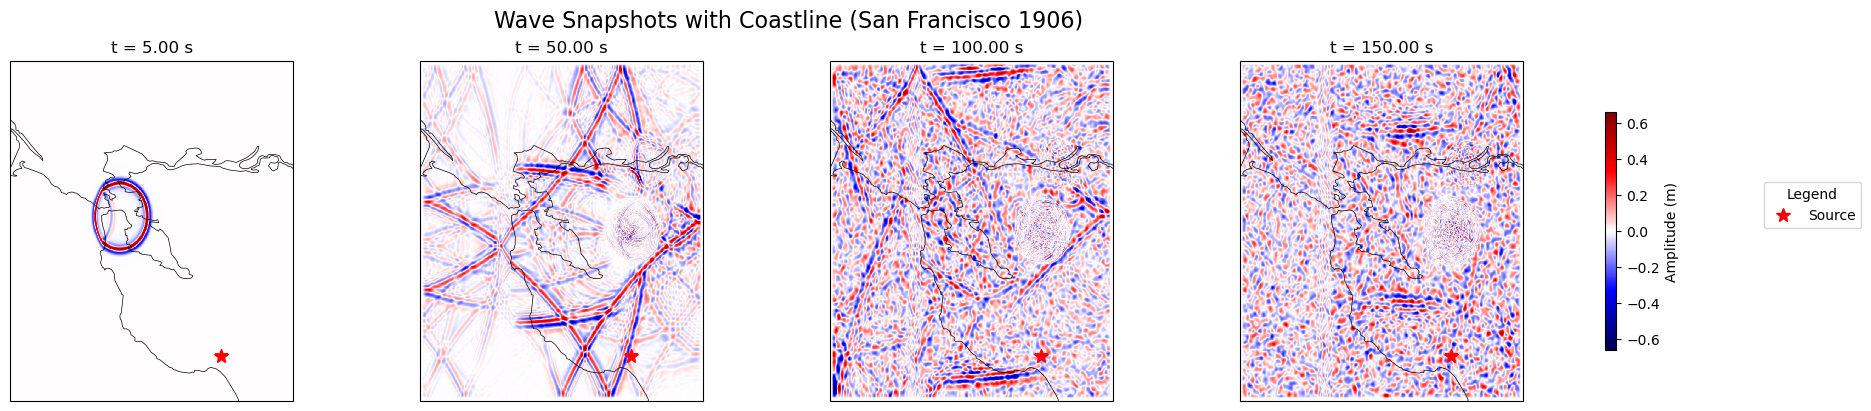

In [31]:
plot_wave_snapshots(
    snapshots, snapshot_times,
    gamma_map,
    domain=[Lx, Ly, T],
    sim_param=[Nx, Ny, dt],
    source_locs=[(37.040, -121.883)],
    bridge_points=bridge_points
)

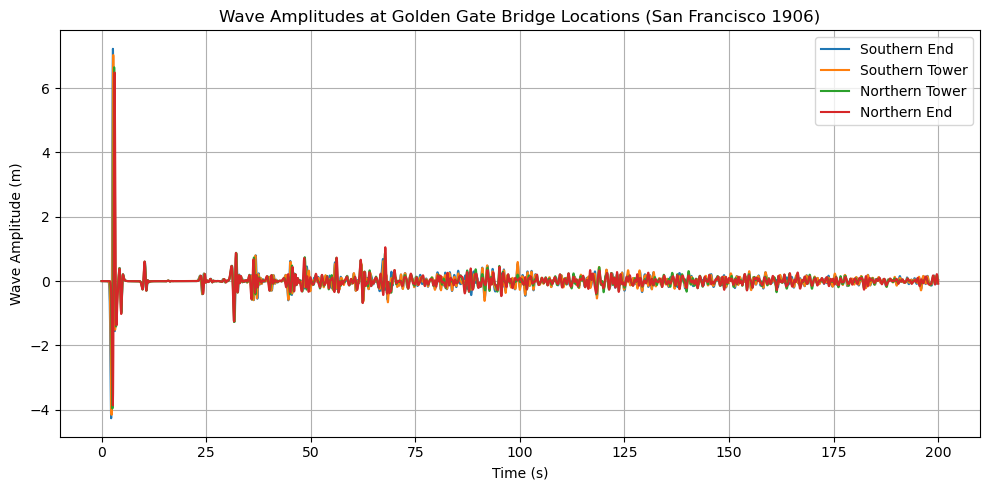

In [32]:
bridge = ['Southern End', 'Southern Tower', 'Northern Tower', 'Northern End']

plt.figure(figsize=(10, 5))
for ptseries, lab in zip(probe_data.items(), bridge):
    pt, series = ptseries
    plt.plot(np.linspace(0, T, len(series)), series, label=lab)#f"Point {pt}")
    print()
plt.xlabel("Time (s)")
plt.ylabel("Wave Amplitude (m)")
plt.title("Wave Amplitudes at Golden Gate Bridge Locations (San Francisco 1906)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

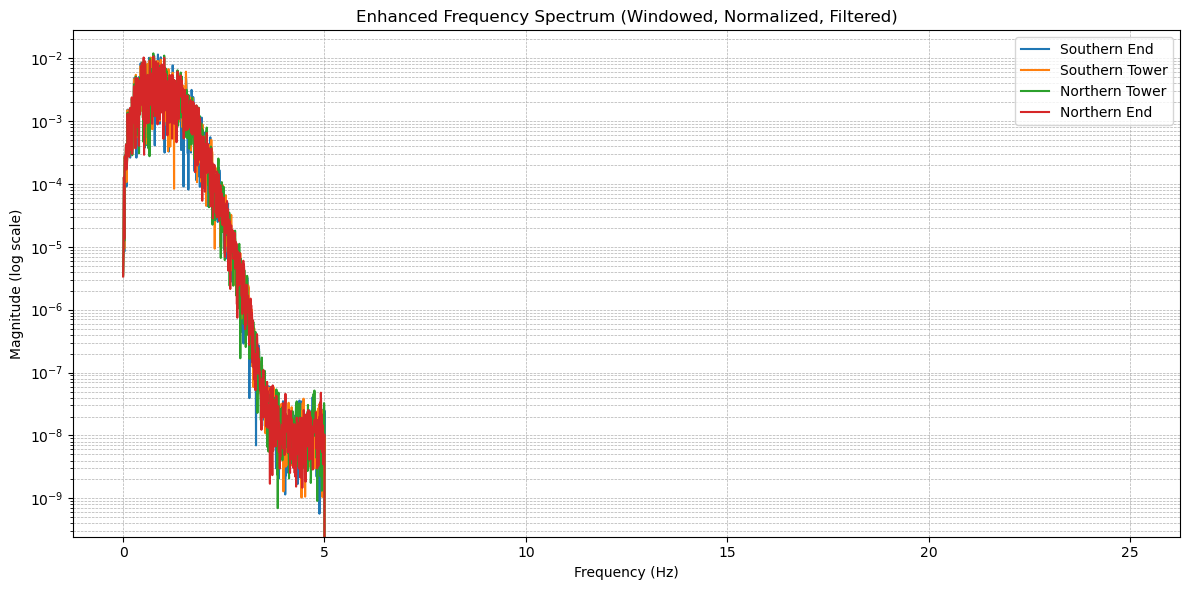

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def apply_hanning_window(series):
    """Apply a Hanning window to the time-domain signal."""
    window = np.hanning(len(series))
    return series * window

def low_pass_filter(freqs, fft_vals, cutoff_hz):
    """Zero out frequencies above the cutoff."""
    filtered_fft = fft_vals.copy()
    filtered_fft[np.abs(freqs) > cutoff_hz] = 0
    return filtered_fft

# Parameters
cutoff_frequency = 5.0  # Hz (you can adjust this as needed)

plt.figure(figsize=(12, 6))

bridge = ['Southern End', 'Southern Tower', 'Northern Tower', 'Northern End']

for ptseries, lab in zip(probe_data.items(), bridge):
    pt, series = ptseries
    N = len(series)            # Number of samples
    dt = T / N                 # Time step
    freqs = np.fft.fftfreq(N, d=dt)  # Frequency bins

    # Apply windowing
    windowed_series = apply_hanning_window(series)

    # FFT computation
    fft_vals = np.fft.fft(windowed_series)
    
    # Normalize magnitude
    magnitude = np.abs(fft_vals) / N

    # Apply low-pass filter (optional — comment out if not needed)
    fft_vals_filtered = low_pass_filter(freqs, fft_vals, cutoff_frequency)
    magnitude_filtered = np.abs(fft_vals_filtered) / N

    # Sort and select positive frequencies
    idx = np.argsort(freqs)
    freqs = freqs[idx]
    magnitude = magnitude[idx]
    magnitude_filtered = magnitude_filtered[idx]
    pos_mask = freqs >= 0

    # Plot filtered FFT
    plt.plot(freqs[pos_mask], magnitude_filtered[pos_mask], label=lab)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (log scale)")
plt.yscale("log")
plt.title("Enhanced Frequency Spectrum (Windowed, Normalized, Filtered)")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()